# Kaggle

Нам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузим тренировочный и тестовый датасеты
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv')

# Для удобства, сохраним Id пассажиров в отдельную переменную
PassengerId = test['PassengerId']

train.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
full_data = [train, test]

# Создадим столбцы с длинной имен пассажиров
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Создадим столбцы наличия каюты у пассажира
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Создадим новый столбец FamilySize из значений Parch и SibSp
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Создадим новый столбец IsAlone из значений FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Удалим все нулевые значения из колонки Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Удалим все нулевые значения из колонки Fare и создадим новую колонку CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Создадим нову колонку CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Напишем функцию для  выделения титула из имен
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Если титул существует, функция вернет его значение
    if title_search:
        return title_search.group(1)
    return ""
# Создадим колонку Title, содержащую титулы пассажиров
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Обозначим все не основные титула как "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Разобьем на категории значения следующих колонок
for dataset in full_data:
    # Пол
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Титулы
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Порт отправления
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Стоимость проезда
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Возраст
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [ ]:
# Удалим ненужные колонки
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


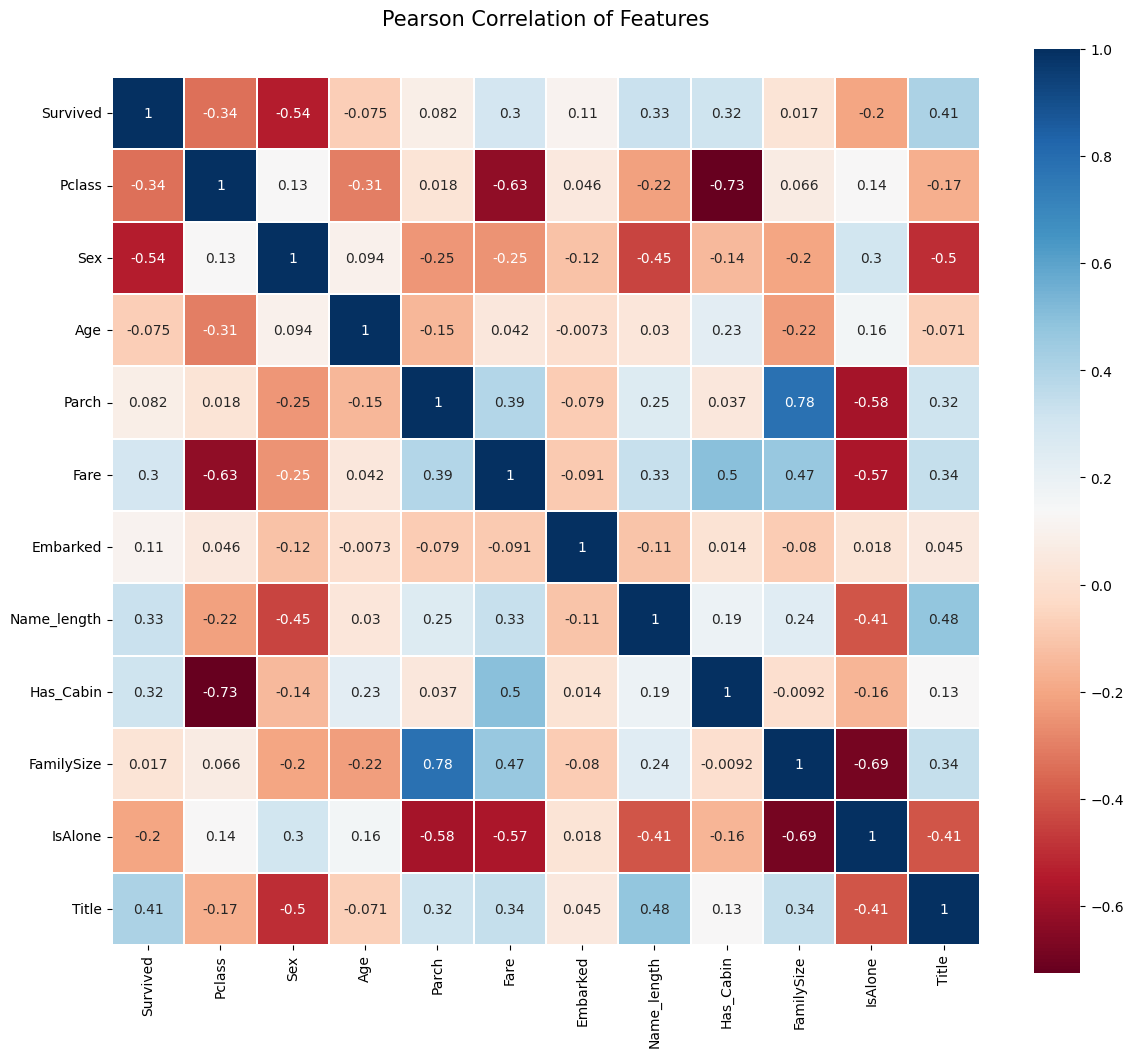

In [ ]:
# Отобразим матрицу коррелцияя Пирсона для выявления зависимостей между колонками
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

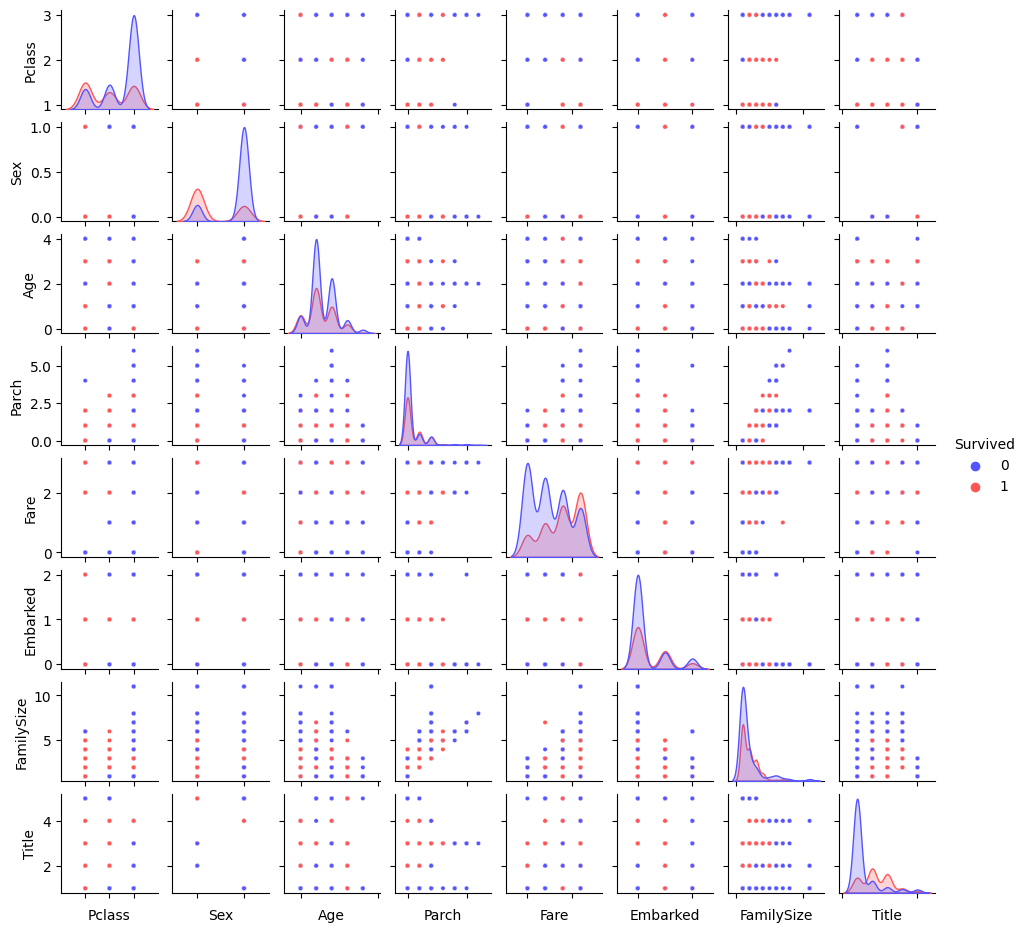

In [ ]:
# Для наглядности, воспользуемся pairplot библиотеки Seaborn
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])
plt.show()

У нас получились два датасета с новыми признаками. Теперь приступим к построению модели.
В качестве базовых алгоритмов используем RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделим данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмем столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [ ]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1),
             'n_estimators': np.arange(1, 10, 1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)} # LogisticRegression

skf = StratifiedKFold(n_splits=5)

In [ ]:
targets = train.Survived
data = train.drop(columns='Survived')

x_train, x_test, y_train, y_test = train_test_split(data,
                                                    targets,
                                                    train_size=0.4,
                                                    random_state=17)



rfc = RandomForestClassifier(random_state=17)
gbc = GradientBoostingClassifier(random_state=17)
lr = LogisticRegression(random_state=17)
svc = SVC(random_state=17)

meta = XGBClassifier(n_estimators=40)

In [ ]:
models = [rfc, svc, lr, gbc]

meta_mtrx = np.empty((len(x_train), len(models)))

for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, x_train, y_train, method='predict')
    model.fit(x_train,y_train)


meta_model = meta.fit(meta_mtrx, y_train)

meta_mtrx_test = np.empty((len(x_test), len(models)))

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(x_test)

meta_predict = meta_model.predict(meta_mtrx_test)

print(f'Stacking accuracy: {accuracy_score(y_test, meta_predict)}')

Stacking accuracy: 0.8130841121495327


Определим объект GridSearchCV для всех приведенных параметров каждого алгоритма. Параметр cv устанавливаем равным skf.
Обучим каждый из объектов на получившейся при разбиении тренировочной выборке. Выведем лучшее сочетание параметров для каждого из алгоритмов. Для каждого обученного алгоритма получим предсказания на валидационных данных и выведим метрику качества, которая соответствует метрике оценки соревнования.

In [ ]:
gs_rfc = GridSearchCV(rfc, rfc_params, cv=skf)
gs_gbc = GridSearchCV(gbc, gbc_params, cv=skf)
gs_lr = GridSearchCV(lr, lr_params)
gs_svc = GridSearchCV(svc, svc_params, cv=skf)

gs_rfc_model = gs_rfc.fit(x_train,y_train)
gs_gbc_model = gs_gbc.fit(x_train,y_train)
gs_lr_model = gs_lr.fit(x_train,y_train)
gs_svc_model = gs_svc.fit(x_train,y_train)

In [ ]:
rfc_best_params = gs_rfc_model.best_params_
gbc_best_params = gs_gbc_model.best_params_
lr_best_params = gs_lr_model.best_params_
svc_best_params = gs_svc_model.best_params_

In [ ]:
print(f'Best parameters for rfc: {rfc_best_params}')
print(f'Best parameters for gbc: {gbc_best_params}')
print(f'Best parameters for lr: {lr_best_params}')
print(f'Best parameters for svc: {svc_best_params}')

Best parameters for rfc: {'min_samples_leaf': 2, 'n_estimators': 40}
Best parameters for gbc: {'learning_rate': 0.4, 'n_estimators': 6}
Best parameters for lr: {'C': 0.5}
Best parameters for svc: {'C': 0.1, 'kernel': 'linear'}


In [ ]:
rfc_pred = gs_rfc_model.predict(x_test)
accuracy_score(y_test, rfc_pred)

0.8242990654205608

In [ ]:
gbc_pred = gs_gbc_model.predict(x_test)
accuracy_score(y_test, gbc_pred)

0.8168224299065421

In [ ]:
lr_pred = gs_lr_model.predict(x_test)
accuracy_score(y_test, lr_pred)

0.8186915887850468

In [ ]:
svc_pred = gs_svc_model.predict(x_test)
accuracy_score(y_test, svc_pred)

0.8074766355140187

С помощью GridSearchCV и указанных ниже параметров настроим мета-алгоритм на мета-признаках (используем 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получим из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведим лучшие параметры.

In [ ]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [ ]:
xgb = XGBClassifier(n_estimators=5, random_state=17)
gs_xgb = GridSearchCV(xgb, xgb_params)


models2 = [rfc_pred, gbc_pred, lr_pred, svc_pred]

meta_mtrx2 = np.empty((len(x_test), len(models2)))

for n,model in enumerate(models2):
    meta_mtrx2[:, n] = model

In [ ]:
gs_xgb_model = gs_xgb.fit(meta_mtrx2, y_test)

In [ ]:
xgb_best_params = gs_xgb_model.best_params_
xgb_best_params

{'eta': 0.7000000000000001,
 'min_child_weight': 2,
 'n_estimators': 25,
 'subsample': 0.5000000000000001}

Построим стекинг (используем 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используем весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделаем прогноз мета-алгоритма для test.csv.

In [ ]:
rfc = RandomForestClassifier(min_samples_leaf=3, n_estimators=10, random_state=17)
gbc = GradientBoostingClassifier(learning_rate=0.2, random_state=17)
lr = LogisticRegression(C=0.7999999999999999, random_state=17)
svc = SVC(C=0.30000000000000004, kernel='linear', random_state=17)

meta = XGBClassifier(learning_rate=0.7000000000000001, min_child_weight=1, n_estimators=20, subsample=0.5000000000000001)

In [ ]:
models = [rfc, svc, lr, gbc]

meta_mtrx = np.empty((len(x_train), len(models)))

for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, x_train, y_train, cv=5, method='predict')
    model.fit(x_train, y_train)


meta_model = meta.fit(meta_mtrx, y_train)

meta_mtrx_test = np.empty((len(test), len(models)))

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)

meta_predict = meta_model.predict(meta_mtrx_test)

С помощью нижеприведенной функции сформируем файл посылки для соревнования и отправим на Kaggle.

In [ ]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [ ]:
write_to_submission_file(meta_predict,PassengerId)

Результат соревнования:

In [ ]:
0.74880

'0.74880'